In [3]:
import torch
import torch.nn as nn
from data_utils import get_train_loader, get_val_loader, get_test_loader, set_seed
from baseline_transformer_architecture import create_small_transformer
from modeling_functions import validate_transformer
from optimizer_scheduler import get_optimizer, get_plateau_scheduler, linear_teacher_scheduler
from tokenizers import Tokenizer
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer

# === Simple token-level dropout ===
def random_token_dropout(input_ids, dropout_prob=0.1, pad_token_id=1):
    keep_mask = (torch.rand_like(input_ids.float()) > dropout_prob).long()
    return input_ids * keep_mask + pad_token_id * (1 - keep_mask)

if __name__ == "__main__":
    torch.cuda.empty_cache()
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    config = {
        "vocab_size": 20000,
        "dropout": 0.1,
        "d_model": 384,
        "nhead": 6,
        "num_encoder_layers": 4,
        "num_decoder_layers": 4,
        "dim_feedforward": 1536
    }

    tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
    pad_idx = tokenizer.token_to_id("[PAD]")

    model = create_small_transformer(**config).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    plateau_scheduler = get_plateau_scheduler(optimizer)
    teacher_scheduler = linear_teacher_scheduler
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

    train_loader = get_train_loader(tokenizer, batch_size=32, num_workers=2)
    val_loader = get_val_loader(tokenizer, batch_size=4, num_workers=0)
    test_loader = get_test_loader(tokenizer, batch_size=4, num_workers=0)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_rouge": [],
        "val_rouge": [],
        "test_loss": None,
        "test_rouge": None,
        "learning_rate": [],
        "teacher_forcing_ratio": [],
    }

    def compute_rouge(reference_ids, prediction_ids):
        refs = [tokenizer.decode(r.tolist(), skip_special_tokens=True) for r in reference_ids]
        preds = [tokenizer.decode(p.tolist(), skip_special_tokens=True) for p in prediction_ids]
        scores = [scorer.score(r, p)["rougeL"].fmeasure for r, p in zip(refs, preds)]
        return sum(scores) / len(scores)

    for epoch in range(2):
        model.train()
        total_loss = 0
        predictions, references = [], []
        tf_ratio = teacher_scheduler.step()

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/5"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attn_mask = batch["attention_mask"].to(device)

            input_ids_aug = random_token_dropout(input_ids, dropout_prob=0.1, pad_token_id=pad_idx)

            optimizer.zero_grad()
            output = model(
                src=input_ids_aug,
                tgt=labels,
                src_key_padding_mask=(attn_mask == 0),
                teacher_forcing_ratio=tf_ratio
            )
            logits = output.view(-1, output.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += loss.item()

            with torch.no_grad():
                predictions.append(output.argmax(dim=-1))
                references.append(labels[:, 1:])

        avg_train_loss = total_loss / len(train_loader)
        train_rouge = compute_rouge(torch.cat(references), torch.cat(predictions))

        torch.cuda.empty_cache()
        val_loss, val_outputs = validate_transformer(model, val_loader, criterion, tokenizer, device, pad_idx, max_length_generate=40)
        val_rouge = compute_rouge(val_outputs["references"], val_outputs["predictions"])

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["train_rouge"].append(train_rouge)
        history["val_rouge"].append(val_rouge)
        history["learning_rate"].append(optimizer.param_groups[0]['lr'])
        history["teacher_forcing_ratio"].append(tf_ratio)

        plateau_scheduler.step(val_loss)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ROUGE: {train_rouge:.4f}, Val ROUGE: {val_rouge:.4f}")

    # === Final Test Evaluation ===
    torch.cuda.empty_cache()
    model.eval()
    total_test_loss = 0
    predictions, references = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attn_mask = batch["attention_mask"].to(device)

            output = model(
                src=input_ids,
                tgt=labels,
                src_key_padding_mask=(attn_mask == 0)
            )
            logits = output.view(-1, output.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            total_test_loss += loss.item()

            pred_ids = output.argmax(dim=-1)
            predictions.append(pred_ids)
            references.append(labels[:, 1:])

    avg_test_loss = total_test_loss / len(test_loader)
    test_rouge = compute_rouge(torch.cat(references), torch.cat(predictions))

    history["test_loss"] = avg_test_loss
    history["test_rouge"] = test_rouge

    print(f"\nTest Loss: {avg_test_loss:.4f} | Test ROUGE-L: {test_rouge:.4f}")

    with open("label_smooth_history.json", "w") as f:
        json.dump(history, f, indent=2)

    epochs = list(range(1, len(history["train_loss"]) + 1))

    # === Loss Plot ===
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="s")
    plt.axhline(y=history["test_loss"], color='r', linestyle='--', label=f"Test Loss: {history['test_loss']:.4f}")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_plot.png")
    plt.show()

    # === ROUGE Plot ===
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_rouge"], label="Train ROUGE-L", marker="o")
    plt.plot(epochs, history["val_rouge"], label="Validation ROUGE-L", marker="s")
    plt.axhline(y=history["test_rouge"], color='g', linestyle='--', label=f"Test ROUGE-L: {history['test_rouge']:.4f}")
    plt.title("ROUGE-L Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROUGE-L F1 Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("rouge_plot.png")
    plt.show()

Epoch 1/5:   0%|          | 0/8973 [00:00<?, ?it/s]

KeyboardInterrupt: 

Epoch 1/2:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 6.1996, Val Loss: 5.4040
  Train ROUGE1: 0.1804, Val ROUGE1: 0.1277
  Train ROUGE2: 0.0148, Val ROUGE2: 0.0151
  Train ROUGEL: 0.1488, Val ROUGEL: 0.1094


Epoch 2/2:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 5.4793, Val Loss: 5.0299
  Train ROUGE1: 0.2227, Val ROUGE1: 0.1444
  Train ROUGE2: 0.0249, Val ROUGE2: 0.0184
  Train ROUGEL: 0.1808, Val ROUGEL: 0.1196
Test ROUGE1: 0.2535
Test ROUGE2: 0.0337
Test ROUGEL: 0.2094


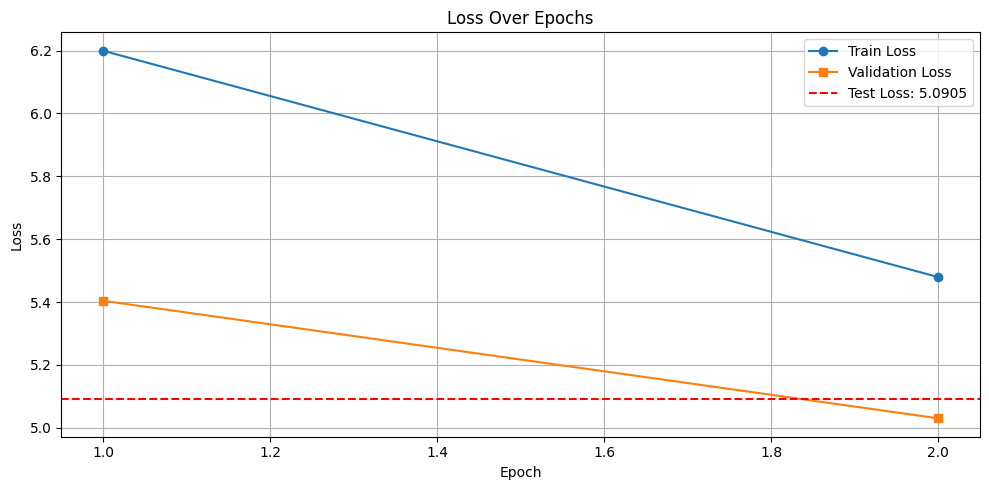

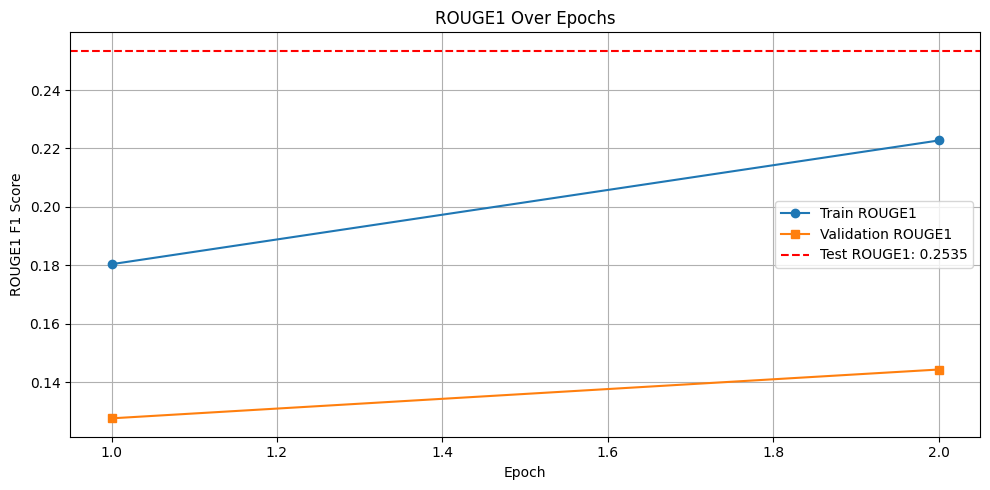

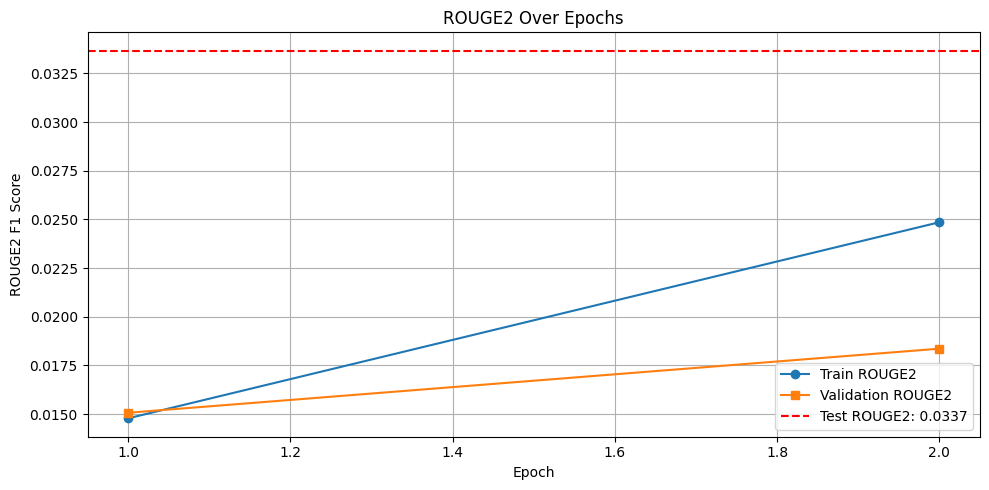

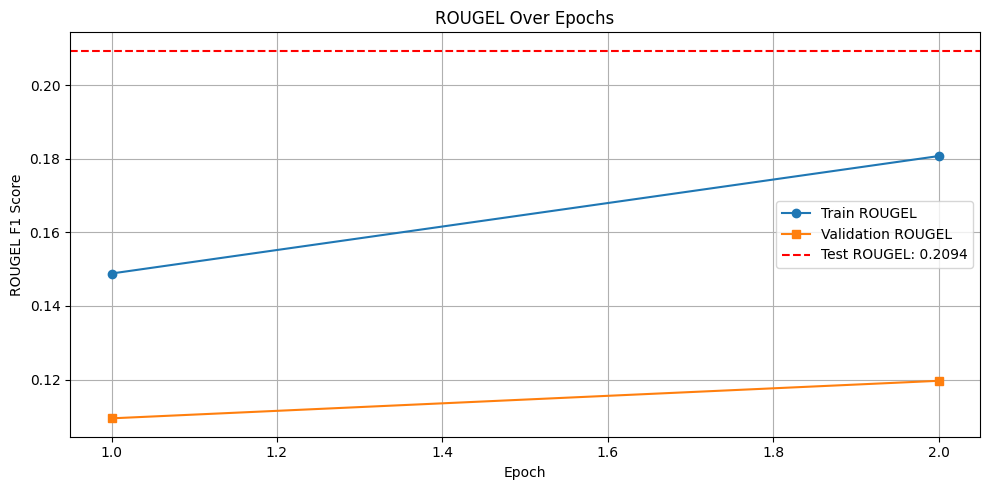

In [5]:
import torch
import torch.nn as nn
from data_utils import get_train_loader, get_val_loader, get_test_loader, set_seed
from baseline_transformer_architecture import create_small_transformer
from modeling_functions import validate_transformer
from optimizer_scheduler import get_optimizer, get_plateau_scheduler, linear_teacher_scheduler
from tokenizers import Tokenizer
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer

# === Simple token-level dropout ===
def random_token_dropout(input_ids, dropout_prob=0.1, pad_token_id=1):
    keep_mask = (torch.rand_like(input_ids.float()) > dropout_prob).long()
    return input_ids * keep_mask + pad_token_id * (1 - keep_mask)

# === ROUGE scoring for training/test sets ===
def compute_rouge(reference_ids, prediction_ids):
    refs = [tokenizer.decode(r.tolist(), skip_special_tokens=True) for r in reference_ids]
    preds = [tokenizer.decode(p.tolist(), skip_special_tokens=True) for p in prediction_ids]
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    for r, p in zip(refs, preds):
        result = scorer.score(r, p)
        for k in scores:
            scores[k].append(result[k].fmeasure)
    return {k: sum(v)/len(v) if v else 0.0 for k, v in scores.items()}

if __name__ == "__main__":
    torch.cuda.empty_cache()
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    config = {
        "vocab_size": 20000,
        "dropout": 0.1,
        "d_model": 384,
        "nhead": 6,
        "num_encoder_layers": 4,
        "num_decoder_layers": 4,
        "dim_feedforward": 1536
    }

    tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
    pad_idx = tokenizer.token_to_id("[PAD]")

    model = create_small_transformer(**config).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    plateau_scheduler = get_plateau_scheduler(optimizer)
    teacher_scheduler = linear_teacher_scheduler
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    train_loader = get_train_loader(tokenizer, batch_size=32, num_workers=2)
    val_loader = get_val_loader(tokenizer, batch_size=4, num_workers=0)
    test_loader = get_test_loader(tokenizer, batch_size=4, num_workers=0)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_rouge1": [],
        "train_rouge2": [],
        "train_rougeL": [],
        "val_rouge1": [],
        "val_rouge2": [],
        "val_rougeL": [],
        "test_loss": None,
        "test_rouge1": None,
        "test_rouge2": None,
        "test_rougeL": None,
        "learning_rate": [],
        "teacher_forcing_ratio": [],
    }

    for epoch in range(2):
        model.train()
        total_loss = 0
        predictions, references = [], []
        tf_ratio = teacher_scheduler.step()

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/2"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attn_mask = batch["attention_mask"].to(device)

            input_ids_aug = random_token_dropout(input_ids, dropout_prob=0.1, pad_token_id=pad_idx)

            optimizer.zero_grad()
            output = model(
                src=input_ids_aug,
                tgt=labels,
                src_key_padding_mask=(attn_mask == 0),
                teacher_forcing_ratio=tf_ratio
            )
            logits = output.view(-1, output.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += loss.item()

            with torch.no_grad():
                predictions.append(output.argmax(dim=-1))
                references.append(labels[:, 1:])

        avg_train_loss = total_loss / len(train_loader)
        train_rouge_scores = compute_rouge(torch.cat(references), torch.cat(predictions))

        torch.cuda.empty_cache()
        val_loss, val_rouge_scores = validate_transformer(
            model, val_loader, criterion, tokenizer, device, pad_idx, max_length_generate=40
        )

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["learning_rate"].append(optimizer.param_groups[0]['lr'])
        history["teacher_forcing_ratio"].append(tf_ratio)

        for k in ["rouge1", "rouge2", "rougeL"]:
            history[f"train_{k}"].append(train_rouge_scores[k])
            history[f"val_{k}"].append(val_rouge_scores[f"{k}_mean"])

        plateau_scheduler.step(val_loss)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        for k in ["rouge1", "rouge2", "rougeL"]:
            print(f"  Train {k.upper()}: {train_rouge_scores[k]:.4f}, Val {k.upper()}: {val_rouge_scores[f'{k}_mean']:.4f}")

    # === Final Test Evaluation ===
    torch.cuda.empty_cache()
    model.eval()
    total_test_loss = 0
    predictions, references = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attn_mask = batch["attention_mask"].to(device)

            output = model(
                src=input_ids,
                tgt=labels,
                src_key_padding_mask=(attn_mask == 0)
            )
            logits = output.view(-1, output.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            total_test_loss += loss.item()

            pred_ids = output.argmax(dim=-1)
            predictions.append(pred_ids)
            references.append(labels[:, 1:])

    avg_test_loss = total_test_loss / len(test_loader)
    test_rouge_scores = compute_rouge(torch.cat(references), torch.cat(predictions))
    history["test_loss"] = avg_test_loss
    for k in ["rouge1", "rouge2", "rougeL"]:
        history[f"test_{k}"] = test_rouge_scores[k]
        print(f"Test {k.upper()}: {test_rouge_scores[k]:.4f}")

    with open("label_smooth_history.json", "w") as f:
        json.dump(history, f, indent=2)

    epochs = list(range(1, len(history["train_loss"]) + 1))

    # === Loss Plot ===
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="s")
    plt.axhline(y=history["test_loss"], color='r', linestyle='--', label=f"Test Loss: {history['test_loss']:.4f}")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_plot.png")
    plt.show()

    # === ROUGE Score Plots ===
    for k in ["rouge1", "rouge2", "rougeL"]:
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, history[f"train_{k}"], label=f"Train {k.upper()}", marker="o")
        plt.plot(epochs, history[f"val_{k}"], label=f"Validation {k.upper()}", marker="s")
        plt.axhline(y=history[f"test_{k}"], color='r', linestyle='--', label=f"Test {k.upper()}: {history[f'test_{k}']:.4f}")
        plt.title(f"{k.upper()} Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel(f"{k.upper()} F1 Score")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{k}_plot.png")
        plt.show()
